In [1]:
%load_ext autoreload
%autoreload 2

import text_processing
import utils
import tf_idf

# Wilde Ride - A Literary Analysis of Oscar Wilde's Corpus
##### Jessica Brown and Lauren Nalajala
## Background
Talk about Oscar Wilde's life here (add image for timeline of his life?)

And the goal of this project here

## Intial Text Processing
Talk about getting the data, processing it (ie. what we removed)

In [ ]:
#Import data from wilde, as well as other authors

## Word Usage
We decided to filter out the most common words from our alliterative sequence function and tf-idf functions to glean more pertinent insights from the data. Below is a plot of the most common words across all books that helped inform the list of common words we filtered from the data.

Import re
Import itertools
Import Text
Made strings
[('https://www.gutenberg.org/files/885/885-0.txt', 'ideal_husband'), ('https://www.gutenberg.org/cache/epub/42704/pg42704.txt', 'salome'), ('https://www.gutenberg.org/files/844/844-0.txt', 'importance_earnest'), ('https://www.gutenberg.org/cache/epub/921/pg921.txt', 'de_profundis'), ('https://www.gutenberg.org/cache/epub/30120/pg30120.txt', 'happy_prince')]
('https://www.gutenberg.org/files/885/885-0.txt', 'ideal_husband')
('https://www.gutenberg.org/cache/epub/42704/pg42704.txt', 'salome')
('https://www.gutenberg.org/files/844/844-0.txt', 'importance_earnest')
('https://www.gutenberg.org/cache/epub/921/pg921.txt', 'de_profundis')
('https://www.gutenberg.org/cache/epub/30120/pg30120.txt', 'happy_prince')


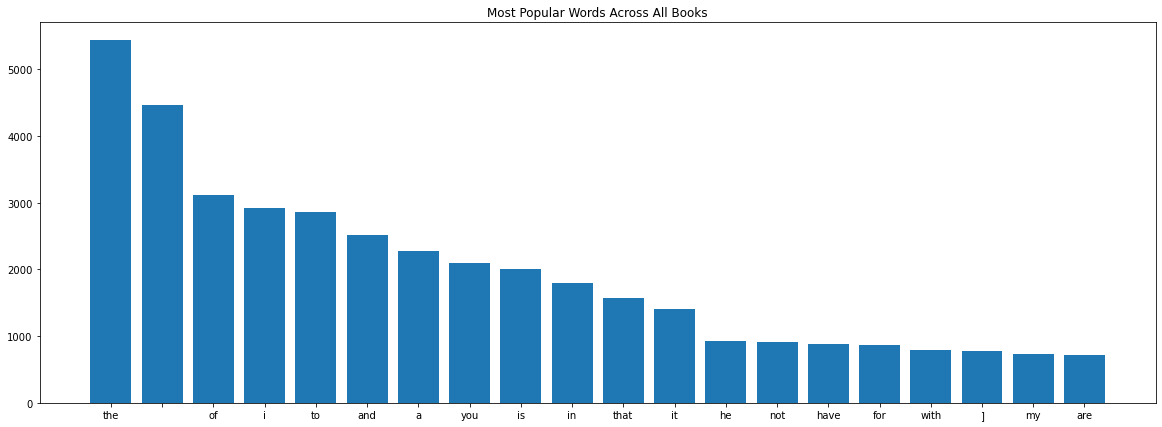

In [1]:
# Plot of most popular words across all books
## Lauren can u replace these urls with ur own txt files of all the books - i just dont have them all downloaded
from utils import plot_most_freq_words_texts
from plotting import plot_freq_bar

# List of tuples, where each tuple corresponds to a text in his corpus. The first tuple index represents the url of the text file, which is helpful
# in extracting the data, and the second index is the name of the book, which ends up being used to name the local text file on our machine.
list_of_urls = [
    ("https://www.gutenberg.org/files/885/885-0.txt", "ideal_husband"),
    ("https://www.gutenberg.org/cache/epub/42704/pg42704.txt", "salome"),
    ("https://www.gutenberg.org/files/844/844-0.txt", "importance_earnest"),
    ("https://www.gutenberg.org/cache/epub/921/pg921.txt", "de_profundis"),
    ("https://www.gutenberg.org/cache/epub/30120/pg30120.txt", "happy_prince"),
]
num_data_pts = 20
freqs = plot_most_freq_words_texts(list_of_urls, num_data_pts)
plot_freq_bar(freqs)

Analyze most commonly used words here

## By the Numbers - some sort of catchy title here?
Numerical analysis of Wilde's writing - average length of words, average length of sentences over time
Maybe a comparison with another book?

In [ ]:
#plots for word length, sentence length of wilde over time\
#also scatter plot of average word/sentence length of wilde's books and compared to other authors

Discuss how Wilde's writing style changed over time, as well as how he compares to other authors of his time

## Polarity
Talk about how we analyzed polarity and make plots of character polarity - maybe connect them back to his life (ie. who/what they represent)

Analyze most commonly used words here

## What counts as an alliterative sequence?
Numerical analysis of Wilde's writing - average length of words, average length of sentences over time
Maybe a comparison with another book?

In [ ]:
#polarity plots here

## TF-IDF
Explain what TF-IDF is, the formula for it, and graph it for individual books\
Also plot TF-IDF of certain words over time 

In [ ]:
#TF-IDF plots here